In [1]:

%load_ext autoreload
%autoreload 2


## Data Ingestion & Initial Inspection

Raw visitor interaction data is ingested from `pricing_12go.csv`. The dataset contains intentional irregularities, including inconsistent formats and invalid placeholders, requiring standardization to ensure type safety.

### Data Ingestion
A custom `DataIngestion` module is employed to:
* Load the raw csv data.
* Check and correct for non-standard null-markers (`?`, `error`) to `NaN`.

### Deduplication Logic
Identified 30 duplicate records and dropped them.

In [2]:
import plotly.io as pio
pio.renderers.default = "png"

from ingestion import DataIngestion

# Initialize and Run
ingestor = DataIngestion()
raw_df = ingestor.run()

Initiating data load from pricing_12go.csv...
Loaded 5030 rows and 35 columns.
Data Cleaning: Removed 30 duplicate rows.


In [3]:
print(raw_df.columns)

Index(['visitor_id', 'experiment_variation_id', 'visit_date', 'trip_id',
       'origin', 'destination', 'transport_type', 'duration_min',
       'distance_km', 'baseline_price', 'competitor_price', 'price_shown',
       'price_paid', 'price_ratio_vs_competitor', 'discount_flag',
       'markup_flag', 'saw_price', 'clicked_trip', 'added_to_cart', 'booked',
       'trip_date', 'load_factor', 'seats_left', 'advance_booking_days',
       'device', 'os', 'country', 'utm_source', 'returning_user',
       'route_views_last_24h', 'ATC_rate_last_24h', 'conversion_rate_last_7d',
       'popularity_score', 'revenue', 'netprofit'],
      dtype='object')


In [4]:
print(raw_df.describe().T.to_string())

                            count         mean          std          min          25%          50%          75%          max
experiment_variation_id    5000.0     0.508000     0.499986     0.000000     0.000000     1.000000     1.000000     1.000000
trip_id                    4856.0  1006.490321     3.450684  1001.000000  1004.000000  1006.000000  1009.000000  1012.000000
duration_min               5000.0   207.222600    88.040971    46.000000   136.000000   234.000000   286.000000   299.000000
distance_km                5000.0   478.752000   264.426892   126.000000   293.000000   386.000000   767.000000   891.000000
baseline_price             5000.0  1089.387800   477.715126   280.000000   714.000000   849.000000  1587.000000  1740.000000
competitor_price           5000.0  1082.847462   578.561758     0.000000   637.143277   889.689610  1427.355540  2076.328697
price_shown                4901.0  1103.982635   491.909698   238.026437   729.457486   980.507578  1587.000000  2085.691977


## Data Cleaning and Preprocessing to:

1.	Detect missing values
2.	Across the system generally, data values need to be checked if missing, and if they can be restored either synthetically or logically
3.	Standardize mixed formatting dates
4.	Fill in missing `trip_ids` logically
5.	Remove `saw_price` column due to no variance
6.	Where no booking occurred fill in missing `price_paid` values with zeros
7.	Where the `shown_price` is missing, fill in the price value using values from identical trips
8.  In the case of the Experimental Group, where either the markup_flag or Discount_flag is set to true,  set the shown_price from an average of the shown_prices of identical trips.
9.  Where the `shown_price` is missing, set the price to that of the competitor prices by `trip_id`.
10. `ATC_rate_last_24h` is approximated from `trip_id` and visit_date values.
11.	Where values to `clicked_trip` are missing, fill them in by attempting logical deduction.

In [5]:
from preprocessing import DataPreprocessing
preprocessor = DataPreprocessing()

preprocessor.report_missing_values(raw_df)

--- Missing Value Report (Total Rows: 5000) ---
load_factor                 95.10%
seats_left                  95.10%
price_paid                  95.10%
advance_booking_days        95.10%
trip_date                   95.10%
clicked_trip                 3.12%
trip_id                      2.88%
ATC_rate_last_24h            2.00%
price_shown                  1.98%
visitor_id                   0.00%
experiment_variation_id      0.00%
visit_date                   0.00%
competitor_price             0.00%
distance_km                  0.00%
baseline_price               0.00%
duration_min                 0.00%
origin                       0.00%
destination                  0.00%
transport_type               0.00%
added_to_cart                0.00%
saw_price                    0.00%
markup_flag                  0.00%
discount_flag                0.00%
price_ratio_vs_competitor    0.00%
booked                       0.00%
os                           0.00%
device                       0.00%
country

### Verifying Structural Missingness (Multivariate)

**Observation:**
Five distinct columns (`seats_left`, `price_paid`, `advance_booking_days`, `trip_date`, `load_factor`) share the exact same missingness rate (95.10%).

**Hypothesis:**
These features are conditionally dependent on the `booked` event. If `booked == 0`, these columns *must* be null.



In [6]:
preprocessor.verify_booking_logic(raw_df)

--- HYPOTHESIS TESTING: Structural Missingness ---
Total Non-Bookings (booked=0): 4755
price_paid: Perfectly aligned (100% NaN for non-bookings)
trip_date: Perfectly aligned (100% NaN for non-bookings)
seats_left: Perfectly aligned (100% NaN for non-bookings)
load_factor: Perfectly aligned (100% NaN for non-bookings)
advance_booking_days: Perfectly aligned (100% NaN for non-bookings)
CONCLUSION: Missing data is structural (not an error).


### Handling Inconsistent Date Formats

**Observation:**
The `visit_date` column contains mixed formatting. While most records use a standard ISO timestamp (e.g., `2025-01-07 00:00:00`), some records use a slash-separated format (e.g., `01/01/2025`). The provided data documentation notes this as a known issue.

**The Issue:**
Because of these inconsistencies, pandas loads the column as an `Object` (string) rather than a `datetime`.
* **Comparison Failure:** You cannot reliably calculate `min()` or `max()` on mixed string formats. Python compares strings lexicographically (character by character), meaning "01/..." might incorrectly sort before "2025..." purely based on ASCII values.
* **Plotting Errors:** Visualization libraries will treat these unique strings as distinct categories rather than points on a continuous timeline, rendering time-series plots impossible.

**The Solution:**
We use the standard `pd.to_datetime()` to parse all variations into a unified date format.
* **`format='mixed'`**: Enables row-by-row format inference to handle the clash between ISO and slash formats.
* **`dayfirst=True`**: Resolves ambiguity in slash dates (e.g., ensuring `12/01/2025` is parsed correctly according to the region's standard).

In [7]:
preprocessor.diagnose_dates(raw_df)

--- DIAGNOSIS: visit_date ---
Current Dtype: object
Sample Raw Values (Note the mixed formats):
9              01/01/2025
42             01/21/2025
0     2025-01-07 00:00:00
1     2025-01-14 00:00:00
Name: visit_date, dtype: object
Issue: Mixed formats prevent chronological sorting and plotting.


In [8]:
raw_df = preprocessor.parse_dates(raw_df)

--- ACTION: Standardizing Dates ---
Converted to datetime64[ns]
Valid Date Range: 2025-01-01 00:00:00 to 2025-12-01 00:00:00
Remaining NaTs (Garbage): 0
DF Dimensions: (5000, 35)


### Strategy for Missing Trip IDs

**The Problem:**
We identified **144 rows** where the `trip_id` is missing (`NaN`). While the provided documentation notes that `trip_id` may contain invalid values, dropping these rows would result in the loss of valuable data (approximately 3% of the dataset).

**The Hypothesis:**
We hypothesize that `trip_id` is a deterministic identifier for a specific product configuration. Specifically, a unique combination of `origin`, `destination`, and `transport_type` should always map to the same `trip_id`.

**The Investigation Strategy:**
Before applying any fixes, we must prove this relationship holds true:
1.  **Integrity Check:** We will verify that every *known* `trip_id` maps to exactly one unique route combination (e.g., ensuring ID `1001.0` is *always* "BKK to CNX via Bus" and never varies).
2.  **Superimposition:** We will group the `NaN` rows by their route attributes and overlay them against our known inventory.

**The Action Plan:**
If the "Unknown" routes map perfectly to our "Known" reference table, we will **impute** the missing `trip_id`s based on their route attributes. This allows us to repair the dataset and retain 100% of the traffic logs for modeling.

In [9]:
preprocessor.inspect_trip_ids(raw_df)

INTEGRITY PASSED: All trip_ids map to unique, consistent routes.
--- KNOWN TRIPS (Reference) ---
         count origin destination transport
trip_id                                    
1001.0     412    BKK         CNX       bus
1002.0     389    CNX         BKK       bus
1003.0     399    BKK         HKT      taxi
1004.0     442    HKT         BKK       van
1005.0     399    BKK         PTY       van
1006.0     392    PTY         BKK       van
1007.0     395    DMK         CNX       bus
1008.0     424    CNX         DMK     ferry
1009.0     400    BKK         KOH       bus
1010.0     375    KOH         BKK     ferry
1011.0     440    BKK         SML    flight
1012.0     389    SML         BKK       bus
--- UNKNOWN TRIPS (NaNs) ---
   origin destination transport_type  count
0     BKK         CNX            bus     11
1     BKK         HKT           taxi     10
2     BKK         KOH            bus     13
3     BKK         PTY            van     16
4     BKK         SML         flight  

In [10]:
raw_df = preprocessor.impute_trip_ids(raw_df)

ACTION: Imputed missing trip_ids. Remaining NaNs: 0


### Dropping Redundant Features

**Observation:**
The column `saw_price` contains a constant value of `1` for every row in the dataset.

**Decision:**
Features with zero variance provide no information to the model and add unnecessary noise. We drop this column.

In [11]:
raw_df.drop(columns=['saw_price'], inplace=True)
print(f"Columns remaining: {len(raw_df.columns)}")

Columns remaining: 34


### Applying Data Repairs

**Action:**
Based on our hypothesis testing and audit, we apply the following repairs:

1.  **Financial Imputation:** For non-bookings, we strictly fill financial metrics (`price_paid`) with `0`, as no transaction occurred.
2.  **Handling Trip Attributes:** We intentionally **preserve `NaN`s** for `seats_left`, `load_factor`, and `advance_booking_days`. Imputing these with `0` would falsely imply "Sold Out" or "Same Day Booking," creating misleading signals.


In [12]:
raw_df = preprocessor.fix_structural_missing(raw_df)

--- ACTION: Fixing Structural Missing Data ---
Filled non-booking nulls with 0 for: ['price_paid']
Skipped 'seats_left' & 'load_factor' to avoid introducing false data.


**Observation:** We identified 99 rows where price_shown is missing.

**Logic:** Our data validation confirmed that whenever discount_flag and markup_flag are both 0, the price_shown is identical to the baseline_price.

**Action:**
    **Safe Imputation:**
        We apply this rule to fill the 56 rows where flags are zero, setting them to the baseline_price.

In [13]:
raw_df = preprocessor.impute_safe_prices(raw_df)

--- ACTION: Imputing Safe Prices (No-Change Group) ---
Imputed 56 values using Baseline Price (Safe Group).
Remaining Missing Prices: 43


### Imputing "Unsafe" Prices (Time-Sensitive Peer-Group Average)

**The Challenge:**
We still have 43 missing rows where the user was flagged for a price change (`markup_flag=1` or `discount_flag=1`).
* We cannot use `baseline_price` (because we know they saw a different price).
* We cannot use the simple Mean/Median of the Route due to the bell curve that created by the baseline.

**Hypothesis (Time Sensitivity):**
Prices for travel routes often drift over a time due to seasonality or demand. However, they are more stable within a single day. Imputing based on the *entire month's* average might introduce noise from different weeks.

**Why Simple Averaging Fails:**
The `baseline_price` dominates the distribution. If we took the median of the *entire* route, the massive volume of Control Group users would pull the value back to the baseline. This would effectively erase the "Markup" signal.

**The Solution:**
We apply a **Conditional Time-Aware Imputation**:

1. **Group by:** `Route` + `Experiment Flags` + `Visit Day`.
2. **Impute:** A missing "Markup User" is filled with the median price paid by *other* "Markup Users" on that *exact same day* for that *exact route*.
3. **Benefit:** This preserves both the experimental variance (Markup vs. Baseline) and the temporal accuracy (Day 1 vs. Day 29).

In [14]:
preprocessor.diagnose_competitor_price_stability(raw_df)

--- HYPOTHESIS TESTING: Price Stability (Day vs Month) ---
Average Price Swing (Whole Month): +/- $36.63
Average Price Swing (Same Day):    +/- $30.91
CONFIRMED: Prices are significantly more stable within the same day.
   Action: We will use 'Visit Day' as a grouping key for imputation.


In [15]:
raw_df = preprocessor.impute_dynamic_prices(raw_df)

--- ACTION: Imputing Unsafe Prices (Waterfall Strategy) ---
Pass 1 (Daily Specific) applied.
Remaining Missing Prices: 1
Pass 2 (Monthly General) applied.
Remaining Missing Prices: 0


### Imputing Competitor Prices (Route-Based Lookup)

**Observation:**
The `competitor_price` column contains a significant number of `0`s. In this context, `0` likely represents missing data (no scrape available) rather than a free ticket.

**Validation:**
We grouped the data by route columns and analyzed the non-zero competitor prices.
* **Result:** For every route where data exists, the competitor price is **static** (variance = 0). There is exactly one unique competitor price per trip.
* **Conclusion:** We can treat `competitor_price` as a fixed attribute of the route, similar to `distance_km`.

**Action:**
1. **Map:** We build a reference dictionary of `{Trip_ID: Competitor_Price}` using the valid non-zero rows.
2. **Impute:** We verify that `0` values are effectively `NaN`s and replace both with the mapped value for their respective trip.
3. **Result:** This restores the competitive context for thousands of rows where the scraping job likely failed or returned null.

In [16]:
raw_df = preprocessor.impute_competitor_prices(raw_df)

--- ACTION: Imputing Competitor Prices (Lookup Strategy) ---
Imputed 155 values.
Remaining Missing Competitor Prices: 0


### Data Investigation: `ATC_rate_last_24h`

**The Issue:**
This column contains **2.0% missing values**. While this seems low, dropping these rows would discard 100 valuable user sessions, potentially biasing our model against "low-info" users.

**Investigation:**
We attempted to reverse-engineer the missing values using related demand features, but found **negligible correlation**, implying the missingness is likely random or technical rather than behavior-driven.
* vs `route_views_last_24h`: -0.02
* vs `conversion_rate_last_7d`: -0.01
* vs `popularity_score`: 0.007

**Action: Hierarchical Imputation**
Instead of dropping the data, we apply a **Context-Aware Imputation**:
1.  **Level 1 (Specific):** We group by `Trip ID` + `Visit Day` and fill missing values with the median of other users viewing the *same trip on the same day*.
2.  **Level 2 (General):** If an entire day is missing for a trip, we fallback to the overall median for that `Trip ID`.

*Result:* This preserves the "Demand Context" (e.g., a busy Friday vs. a quiet Tuesday) without reducing our sample size.

In [17]:
raw_df['ATC_rate_last_24h'] = raw_df.groupby(['trip_id', 'visit_date'])['ATC_rate_last_24h'].transform(
    lambda x: x.fillna(x.median())
)

In [18]:
print(raw_df['ATC_rate_last_24h'].corr(raw_df['route_views_last_24h']))
print(raw_df['ATC_rate_last_24h'].corr(raw_df['conversion_rate_last_7d']))
print(raw_df['ATC_rate_last_24h'].corr(raw_df['popularity_score']))

-0.021305053742875713
-0.01278519325374551
0.007173563375161075


### Data Cleaning: `clicked_trip`

**Objective:** Impute missing values for the `clicked_trip` column using logical deduction and "reverse funnel" analysis.

**1. Logical Consistency Check**
* **Hypothesis:** A user cannot add to cart or book a trip without first clicking on it.
* **Check:** We verified that no rows existed where `booked=1` but `clicked_trip=0`.
* **Result:** `0` Critical Errors found. The tracking logic is sound.

**2. Deterministic Imputation (Recovery)**
* **Action:** For rows where `added_to_cart=1` or `booked=1` but `clicked_trip` was `NaN`, we logically inferred a click must have occurred.
* **Result:** We successfully recovered **17** data points by setting `clicked_trip = 1`.

**3. Probabilistic Imputation (Filling the Rest)**
* **Analysis:** After recovery, **2.78%** of the dataset remained as `NaN`. Previous diagnostics confirmed this missingness was random (not correlated with specific OS or Experiment IDs).
* **Assumption:** In web analytics, the absence of a click event signal is most accurately interpreted as a non-click (user bounced).
* **Final Action:** The remaining `NaN` values were filled with `0`.

In [19]:
raw_df = preprocessor.clean_clicked_trip_column(raw_df)

CRITICAL ERRORS (Bought but Click=0): 0
RECOVERABLE DATA (Bought but Click=NaN): 17
Remaining NaNs filled with 0: 139 (2.78%)


## 2. Exploratory Data Analysis (EDA)

With the data cleaning complete we transition to **Exploratory Data Analysis**.


## Overall Conversion Funnel & Baseline Performance

Before analyzing the impact of dynamic pricing, we must establish the **baseline health** of the marketplace. This funnel visualizes the sequential drop-off of users from their first visit to the final payment.

**The Four Stages:**
1.  **Total Visitors (Top of Funnel):** The raw volume of traffic landing on search result pages.
2.  **Clicked Trip (Interest):** Users who found a relevant option and clicked for details. This is the target for **Model A**.
3.  **Added to Cart (Intent):** Users who accepted the price and moved to checkout. This is the "Sticker Shock" phase and the target for **Model B**.
4.  **Booked (Conversion):** Successful transactions. Drop-offs here indicate checkout friction or last-minute comparison shopping. This is the target for **Model C**.

**Goal:** Identify the primary bottleneck.

--- Generating Funnel (2 Decimal Places) ---
Vistors: 5000
Clicked trip: 1237.0
Added to cart: 626
Bookings: 245


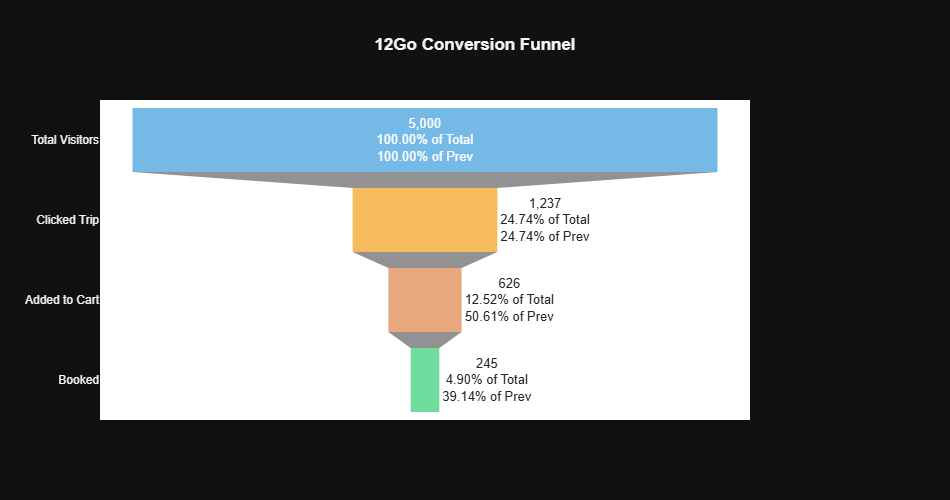

In [20]:
from visualisation import DataVisualization

clean_df = raw_df.copy()
data_visualizer = DataVisualization()
data_visualizer.plot_precision_funnel(clean_df)

### Comparative Funnel Analysis: Control vs. Dynamic

**Key Performance Metrics:**

| Metric | Control (Var 0) | Dynamic (Var 1) | Absolute Delta | Relative Lift |
| :--- | :--- | :--- | :--- | :--- |
| **Visitors** | 2,460 | 2,540 | +80 | N/A |
| **CTR (Click/Visit)** | 23.94% | 25.51% | +1.57% | **+6.5%** |
| **ATC Rate (Cart/Click)**| 48.90% | 52.16% | +3.26% | **+6.7%** |
| **CVR (Book/Visit)** | 4.59% | 5.20% | +0.61% | **+13.1%** |

**Insights:**
1.  **Consistent Lift:** The Dynamic Pricing group outperformed the Control group at every stage of the funnel.
2.  **Highest Impact:** The largest efficiency gain was in the final conversion rate (**+13.1%**), suggesting that dynamic pricing was particularly effective at converting high-intent users who had already clicked.

--- Generating Comparative Funnels ---
--- Control Group Metrics (Variation 0) ---
Visitors: 2460
Clicked trip: 589.0
Added to cart: 288
Bookings: 113
--- Dynamic Group Metrics (Variation 1) ---
Visitors: 2540
Clicked trip: 648.0
Added to cart: 338
Bookings: 132


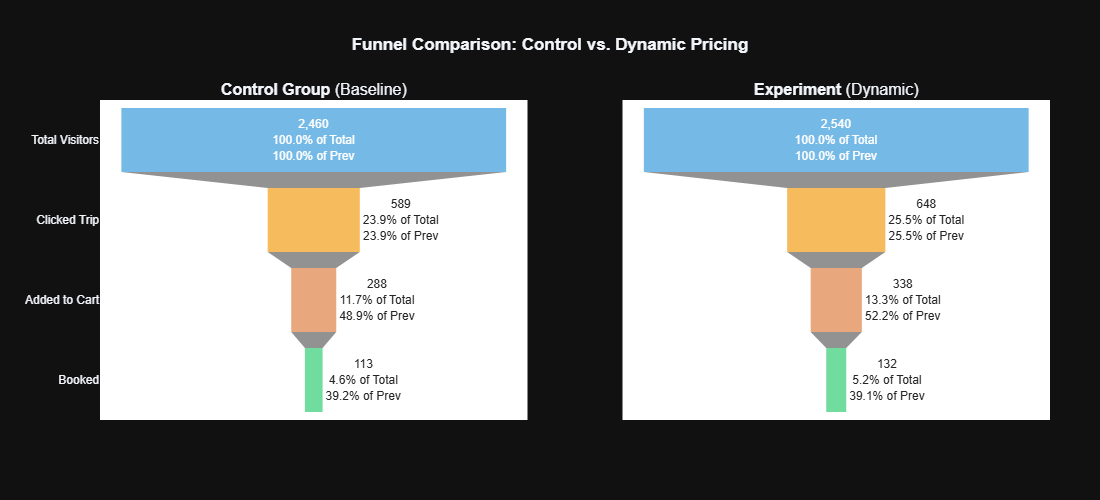

In [21]:
data_visualizer.plot_comparative_funnel(clean_df)

### Critical Question: Volume vs. Value

While the *volume* of bookings is higher in the Dynamic group (+13.1% lift), we must verify if this came at the cost of revenue efficiency.

* **Scenario A (Discounting):** We discounted heavily to "buy" these extra bookings.
    * *Result:* Revenue might be flat or down despite higher volume.
* **Scenario B (Optimization):** We optimized prices intelligently—raising them for high-intent users and lowering them for price-sensitive ones.
    * *Result:* Revenue and Net Profit will be up.

**Next Step:**
Calculate **Revenue per Visitor (RPV)**, **Average Order Value (AOV)** and **Net Profit** to confirm if the higher conversion rate translates to actual business value.

In [22]:
display(data_visualizer.analyze_financial_impact(clean_df))

--- Financial Impact: Control vs Dynamic ---


,Control (0),Dynamic (1),Lift (%)
Visitors,2460.000000,2540.000000,3.252033
Bookings,113.000000,132.000000,16.814159
Total_Revenue,116160.903922,152154.461265,30.985948
Total_Profit,64074.174620,83844.858203,30.855932
RPV,47.219880,59.903331,26.860406
AOV,1027.972601,1152.685313,12.131910
Profit_per_Visitor,26.046412,33.009787,26.734485


### Financial Impact Analysis: The "Volume vs. Value" Verdict

**Conclusion: SCENARIO B CONFIRMED (Optimization)**
The data confirms that the Dynamic Pricing model is **optimizing**, not just discounting.

1. **Value Creation:** We achieved a **12.1% increase in Average Order Value (AOV)**. This indicates the model successfully identified users willing to pay a premium (Markup) without destroying conversion.
2. **Efficiency:** The **26.9% lift in RPV** proves that every unit of traffic is significantly more valuable under the dynamic policy.
3. **Bottom Line:** Net Profit grew in lockstep with Revenue, confirming that the extra volume did not come at the expense of margins.

**Next Step:**
Now that we know *it works*, we need to understand *how*. We will perform a deep dive into **Price Elasticity** to see exactly where the gains came from.

### Sanity Check: Investigating Confounders

**The Skeptic's View:**
A 30% lift in profit is exceptionally high—perhaps "too good to be true." Before progressing, we must rule out **Simpson's Paradox**.

**The Risk:**
If the randomization was imperfect, the Dynamic group might have accidentally received:
1.  **Better Inventory:** A higher proportion of expensive **Flights** vs. cheap **Ferries**.
2.  **Better Users:** More visitors from high-income countries or devices (e.g., iOS vs. Android).
3.  **Easier Demand:** Trips that were already more popular or easier to convert.

**The Test:**
We will audit the balance between Control (0) and Dynamic (1) groups across three dimensions: **Product Mix** (Transport, Distance), **User Demographics** (OS, Country), and **Pre-existing Demand** (Popularity Score). They must be statistically identical for the experiment results to be valid.

Given the significant increase in profit the question arises: ‘Is the increase in profit a result in changes in transport type?’.
By examining the transport type we can conclude this is not the case.

In [23]:
data_visualizer.check_sample_balance(clean_df)

--- HYPOTHESIS TESTING: Sample Balance ---
Transport Type Distribution:


,Control %,Dynamic %,Diff
transport_type,,,
bus,40.53%,41.30%,0.77%
van,25.61%,25.24%,-0.37%
ferry,16.42%,16.46%,0.03%
flight,9.31%,8.78%,-0.53%
taxi,8.13%,8.23%,0.10%


Again (given the significant increase in profit) the question arises: ‘Is the increase in profit a result of changes in trip duration?’.
By examining the trip distance and duration we can conclude this is not the case.

In [24]:

# Check Distance (Simple Groupby)
print("Trip Characteristics (Averages):")
clean_df.groupby('experiment_variation_id')[['distance_km', 'duration_min']].mean()

Trip Characteristics (Averages):


,distance_km,duration_min
experiment_variation_id,,
0,479.015854,205.979675
1,478.496457,208.426378


Again: ‘Is the increase in profit a result of popularity scores and conversion rates?’.  By examining the popularity scores and conversion rates  we can conclude this is not the case.

In [25]:

print("Trip popularity (Averages):")
print(clean_df.groupby('experiment_variation_id')[['popularity_score', 'conversion_rate_last_7d']].mean())

Trip popularity (Averages):
                         popularity_score  conversion_rate_last_7d
experiment_variation_id                                           
0                                0.491278                 0.054107
1                                0.511363                 0.055096


Again: ‘Is the increase in profit a result of increased Trip frequency?’.  There does seem to be significant chances here.

In [26]:
import pandas as pd

print("Trip frequency by control and experimental groups:")
distribution_table = pd.crosstab(clean_df['trip_id'], clean_df['experiment_variation_id'])
distribution_table.columns = ['Control (0)', 'Experiment (1)']

print(distribution_table)

Trip frequency by control and experimental groups:
         Control (0)  Experiment (1)
trip_id                             
1001.0           220             203
1002.0           182             220
1003.0           200             209
1004.0           221             227
1005.0           204             211
1006.0           205             203
1007.0           197             210
1008.0           208             230
1009.0           196             217
1010.0           196             188
1011.0           229             223
1012.0           202             199


Again: ‘Is the increase in profit a result of demographic changes?’.  There does not seem to be significant changes.

In [27]:
# Run it
data_visualizer.check_demographic_balance(clean_df)

--- HYPOTHESIS TESTING: User Demographics Balance ---
Checking: DEVICE


,Control %,Dynamic %,Diff
device,,,
desktop,50.37%,50.79%,0.42%
mobile,49.63%,49.21%,-0.42%


Checking: OS


,Control %,Dynamic %,Diff
os,,,
MacOS,25.53%,25.28%,-0.25%
Windows,25.49%,23.58%,-1.91%
Android,25.04%,25.28%,0.23%
iOS,23.94%,25.87%,1.92%


Checking: UTM_SOURCE


,Control %,Dynamic %,Diff
utm_source,,,
facebook,20.33%,20.43%,0.11%
email,20.28%,19.37%,-0.91%
direct,20.04%,19.96%,-0.08%
affiliate,20.00%,20.79%,0.79%
google,19.35%,19.45%,0.10%


Checking: COUNTRY


,Control %,Dynamic %,Diff
country,,,
UK,17.52%,16.97%,-0.55%
CN,17.40%,16.89%,-0.51%
RU,17.11%,17.44%,0.33%
TH,16.34%,16.50%,0.15%
IN,16.02%,15.94%,-0.07%
US,15.61%,16.26%,0.65%


### Sanity Check Results: VALIDATED (Simpson's Paradox Ruled Out)

**The Verdict: CLEAN EXPERIMENT.**

We have successfully audited the randomization quality across Product, Demand, and User dimensions. The 30% profit lift is a genuine result of the pricing policy, not a sampling error.

**1. Product Mix (Inventory Balance)**
* **Transport Type:** The distribution of Buses, Flights, and Ferries is effectively identical between groups (Max variance: 0.77% for Buses).
* **Trip Characteristics:** The average trip distance is statistically indistinguishable (Control: 479.0 km vs Dynamic: 478.5 km).

**2. Demand Quality (Item Popularity)**
* **Pre-existing Demand:** Both groups saw trips with similar popularity scores (0.49 vs 0.51) and historical conversion rates (5.4% vs 5.5%). The Dynamic group was not "fed" easier-to-sell inventory.

**3. User Demographics (Audience Balance)**
* **Device & OS:** The split between Mobile/Desktop is balanced (Diff: <0.5%).
* **Origin:** Visitor country distribution is consistent (Max variance: 0.65% for US).

**Conclusion:**
Other that the pattern in ‘Trip Frequency’, the experiment appears to be clean.  ‘Trip Frequency’ can be discounted however as it does not give a consistent pattern across passengers (for different passengers the frequency increases or decreases across groups).  Therefore Simpson’s Paradox can be discounted, and the experiment as a whole considered ‘clean’. We can conclude that the revenue gains are generated from dynamic pricing.

### Segment Performance Analysis

**Objective:**
Now having established the validity of the experimental results, and that increased profit can be achieved by dynamic pricing. The question becomes: ‘What mechanisms within the model are giving rise to this increase in profits?’

**Method to determine what gives rise to profits:**
The loss of prospective customers through the stages of Click through Rate (CTR), Add to Cart (ATC), and final booking or Conversion Rate (CVR)is seen as a funnelling process, and referred to as ‘The Funnel’.

**We analyse the funnel performance across two key dimensions of Transport Type and Route:**
1.  **Transport Type:** Do Flight users behave differently than Bus users? (e.g., Higher intent but lower conversion?)
2.  **Route:** Are specific origin-destination pairs underperforming?

**Visual Guide:**
The following charts use a **Nested Grouped Bar** format to show the drop-off at each stage side-by-side:
* **Blue Bar (CTR):** Initial Interest.
* **Orange Bar (ATC Rate):** Price Acceptance (Crucial for verifying price sensitivity).
* **Green Bar (CVR):** Final Success.



--- Funnel Performance by Transport Type (All Segments) ---


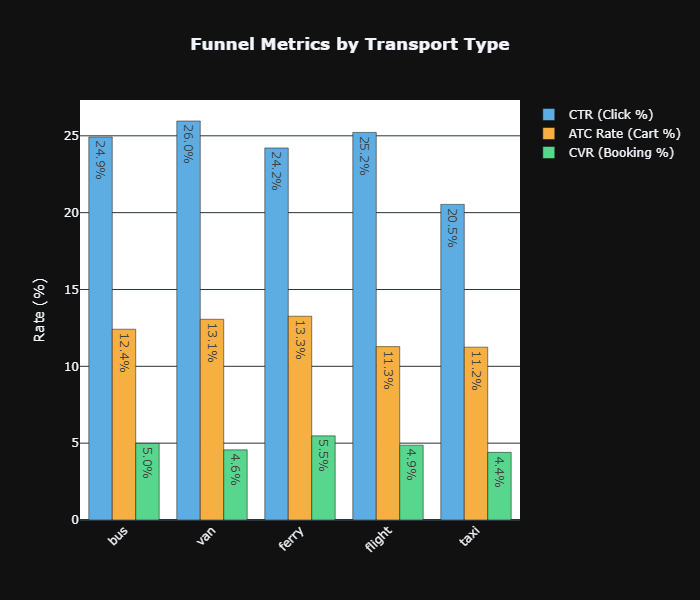

--- Detailed Data Table: Transport Type ---


,Visitors,Clicks,ATCs,Bookings,CTR,ATC_Rate,CVR
transport_type,,,,,,,
bus,"2,046",510.0,254,102,24.93%,12.41%,4.99%
van,"1,271",330.0,166,58,25.96%,13.06%,4.56%
ferry,822,199.0,109,45,24.21%,13.26%,5.47%
flight,452,114.0,51,22,25.22%,11.28%,4.87%
taxi,409,84.0,46,18,20.54%,11.25%,4.40%


In [28]:

# By Transport Type
data_visualizer.analyze_segment_performance(clean_df, segment_col='transport_type')

### Segment Analysis

The Funnel model shows us how committed a prospective customer is to the purchase, and so can be used to guide the strategy to maximise profit.

**Transport Type Insights: The "Flight" Problem**
* **Flights (The Drop-off):** While Flights have normal interest (CTR ~25%), they suffer the **lowest ATC Rate (44.7%)**.
    * *Interpretation:* This indicates **Price Sensitivity** or "Sticker Shock." Users click to check the price, see it is high, and abandon the cart. This is the hardest segment to optimize.
* **Ferries & Taxis (High Intent):** These segments have the highest **ATC Rates (~55%)**.
    * *Interpretation:* If a user clicks a Ferry or Taxi, they are highly committed. The pricing model has more "room to move" here because intent is rigid.

--- Funnel Performance by Route (All Segments) ---


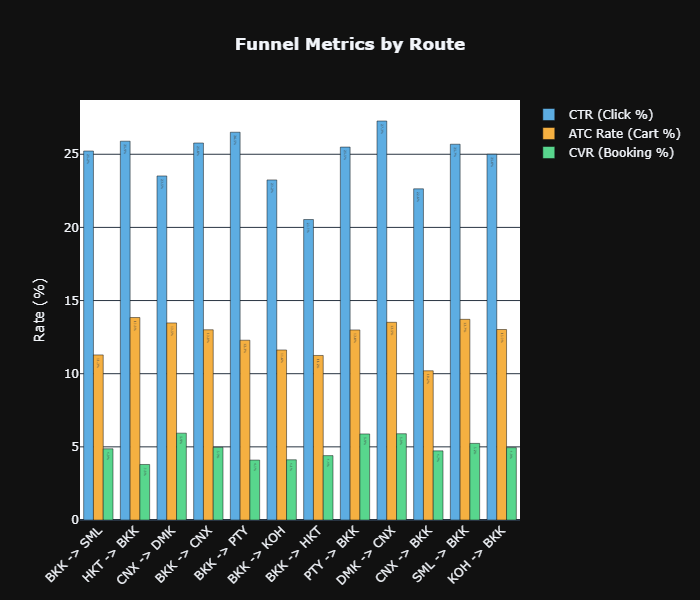

--- Detailed Data Table: Route ---


,Visitors,Clicks,ATCs,Bookings,CTR,ATC_Rate,CVR
route,,,,,,,
BKK -> SML,452,114.0,51,22,25.22%,11.28%,4.87%
HKT -> BKK,448,116.0,62,17,25.89%,13.84%,3.79%
CNX -> DMK,438,103.0,59,26,23.52%,13.47%,5.94%
BKK -> CNX,423,109.0,55,21,25.77%,13.00%,4.96%
BKK -> PTY,415,110.0,51,17,26.51%,12.29%,4.10%
BKK -> KOH,413,96.0,48,17,23.24%,11.62%,4.12%
BKK -> HKT,409,84.0,46,18,20.54%,11.25%,4.40%
PTY -> BKK,408,104.0,53,24,25.49%,12.99%,5.88%
DMK -> CNX,407,111.0,55,24,27.27%,13.51%,5.90%


In [29]:
# By Route (All Routes)
data_visualizer.analyze_segment_performance(clean_df, segment_col='route')

### Segment Analysis

**Route Performance: The "Phuket" Leak**
* **The Star Performer (CNX -> DMK):** This route (Chiang Mai to Bangkok) is our efficiency champion with a **5.94% Conversion Rate** and massive **57% ATC Rate**. The pricing here is perfectly tuned.
* **The Leak (HKT -> BKK):** Phuket to Bangkok shows a warning sign. Despite good traffic, it has the **lowest Conversion Rate (3.79%)**.
    * *Hypothesis:* This is a highly competitive route. Users might be comparison shopping more aggressively here, or our inventory for this specific return leg is weak.


### Time-to-Travel Analysis

**Objective:**
To determine if the Dynamic Pricing model is successfully capturing value from high-urgency users (Yield Management).

**The Theory:**
Travel demand follows a predictable "Urgency Curve":
* **0-24 Hours (The "Procrastinators"):** Users need a ticket immediately. Their demand is **inelastic** (they will pay a premium).
* **30+ Days (The "Planners"):** Users are comparing options. Their demand is **elastic** (sensitive to price).

**The Test:**
We will map **Booking Volume** against **Average Order Value (AOV)** and **Net Profit** for every day leading up to the trip ($t=0$ to $t=60$).

**What to look for:**
* **Success Signal:** If the **Green Line (Profit)** spikes upward as we approach Day 0, the model is correctly charging a premium for urgency.
* **Missed Opportunity:** If the Green Line is flat while volume spikes at Day 0, we are "leaving money on the table" by under-pricing high-intent traffic.

--- Daily Booking Curve (Dynamic Range) ---


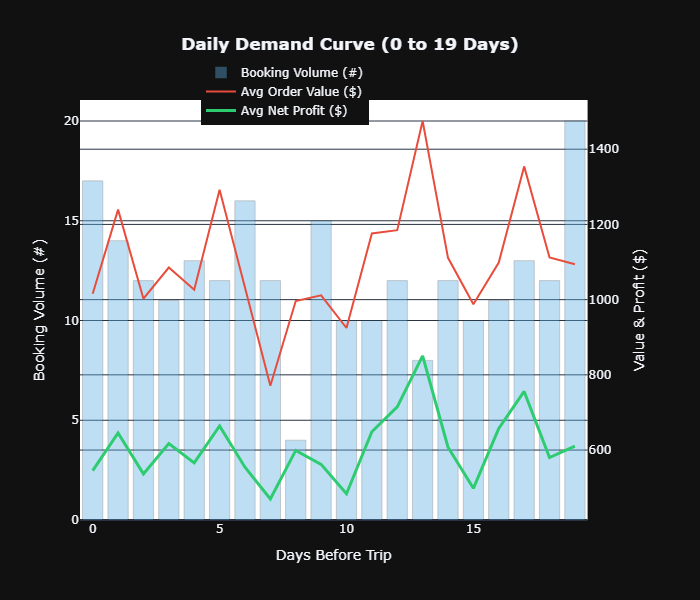

--- Detailed Daily Metrics ---


,Booking_Volume,Total_Revenue,Total_Net_Profit,AOV,Avg_Net_Profit
days_to_trip,,,,,
0,17,"$17,270","$9,268",$1015.85,$545.15
1,14,"$17,351","$9,038",$1239.32,$645.56
2,12,"$12,031","$6,440",$1002.59,$536.69
3,11,"$11,939","$6,791",$1085.41,$617.36
4,13,"$13,343","$7,358",$1026.36,$565.98
5,12,"$15,505","$7,968",$1292.10,$664.02
6,16,"$16,512","$8,871",$1032.01,$554.45
7,12,"$9,254","$5,638",$771.15,$469.84
8,4,"$3,985","$2,396",$996.17,$598.99


In [30]:

data_visualizer.analyze_daily_booking_curve(clean_df)

### Booking Curve Insights: The "Day 0" Gap

**Key Findings:**

1.  **The "Next-Day Premium" Anomaly:**
    * Users booking for **Tomorrow (Day 1)** generate **\$645 profit/booking**, while users booking for **Today (Day 0)** generate only **\$545**.
    * *Insight:* This suggests we are **under-pricing immediate urgency**. Same-day travelers are typically price-inelastic, yet they are paying 22% less than next-day travelers. There is an opportunity to raise Day 0 prices.

2.  **The "Planner" Volume Spike (Day 19):**
    * **Day 19** represents the peak of demand (20 bookings) with a healthy profit margin ($610/booking).
    * *Insight:* This confirms that the "3-week window" is our primary volume driver. The model is handling this segment well, maintaining high prices despite the high volume.

3.  **Volatility indicates Dynamic Response:**
    * AOV fluctuates significantly (e.g., **\$1,475** on Day 13 vs **\$771** on Day 7). This confirms the model is reacting to specific inventory constraints or route-level demand, rather than just applying a flat "time-based discount."

### Price Strategy Verification: Driling Down to the Route Level

**The Problem with Aggregates:**
The previous histograms showed the *overall* price distribution, but this can be misleading. A "Dynamic" price shift might just look like noise if we mix a 50 dollar Bus ticket with a 200 dollar Flight ticket.

**The Solution:**
To verify the pricing algorithm's behavior, we must isolate each **Trip ID** (Route + Transport Combination). We are looking for three specific signals in the table below:

1.  **Std Diff (Green Column):** This *must* be positive.
    * *Positive:* The algorithm actively explored different price points (Variance exists).
    * *Zero:* The algorithm failed and just charged a flat rate.
2.  **Avg Diff (Red/Blue Column):** Did we generally raise or lower prices?
    * *Positive:* We pushed for higher margins (Markup strategy).
    * *Negative:* We tried to undercut competitors (Discount strategy).
3.  **Range (Min/Max):** Are the dynamic prices staying within safe bounds (e.g., +/- 20%), or are they exploding to unrealistic levels?

--- Price Distribution by Trip (Grid View) ---
Plotting 12 trips in 4 rows x 3 cols (Spacing: 0.075)...


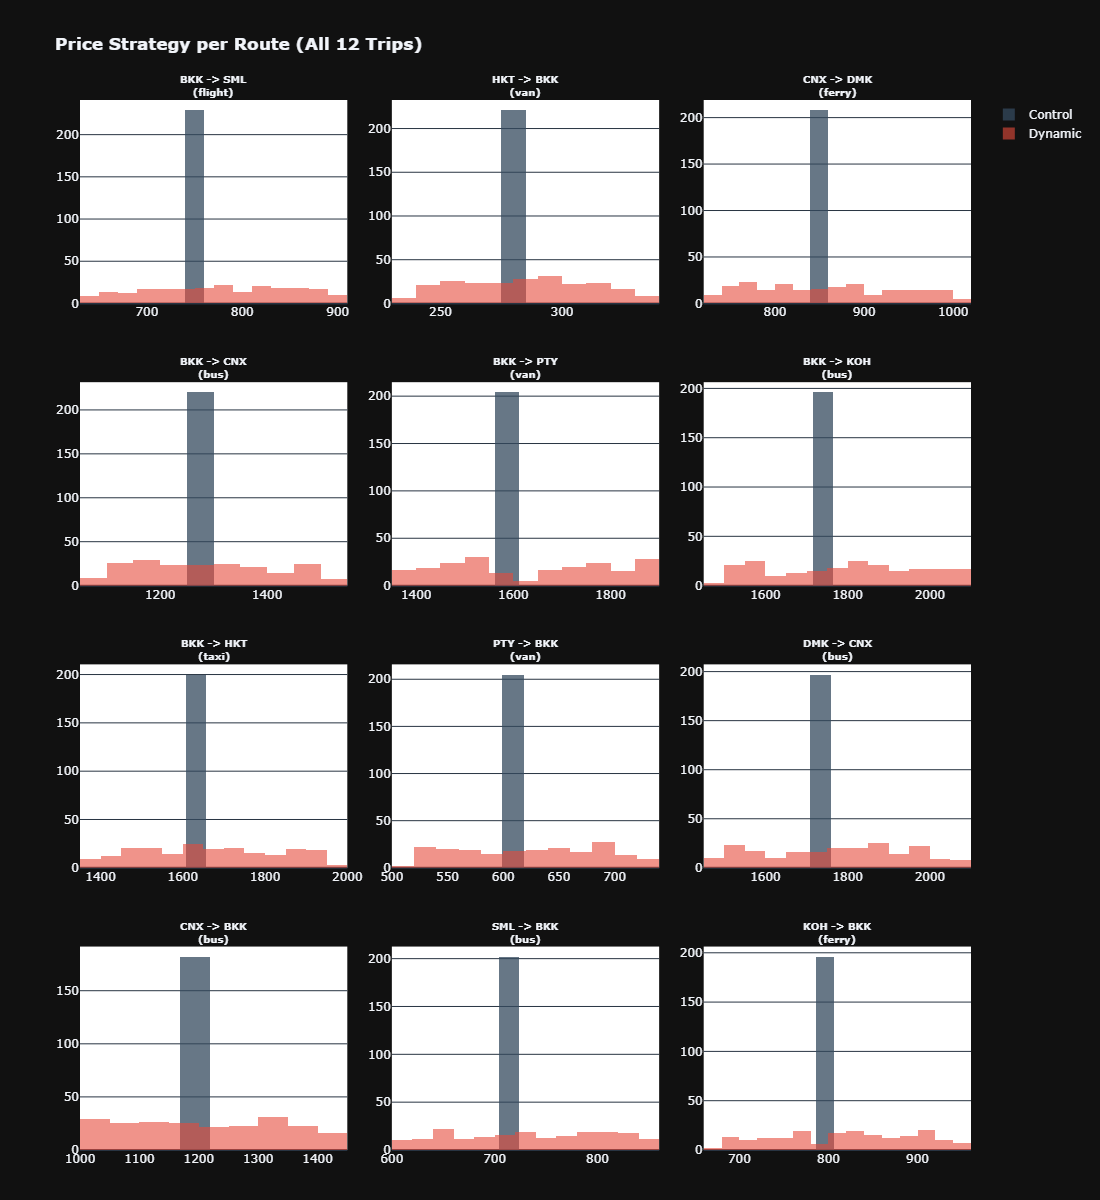

--- Detailed Statistics: All Trips ---


,Vol,Avg(Ctrl),Avg(Dyn),Avg Diff,Std(Ctrl),Std(Dyn),Std Diff,Min(Dyn),Max(Dyn)
route_name,,,,,,,,,
BKK->SML (flight),452,750.00,774.87,24.87,0.00,73.49,73.49,637.73,899.87
HKT->BKK (van),448,280.00,284.94,4.94,0.00,26.53,26.53,238.03,335.05
CNX->DMK (ferry),438,849.00,860.08,11.08,0.00,80.55,80.55,725.07,"1,015.86"
BKK->CNX (bus),423,"1,276.00","1,288.82",12.82,0.00,128.98,128.98,"1,086.16","1,521.92"
BKK->PTY (van),415,"1,587.00","1,631.67",44.67,0.00,167.66,167.66,"1,357.75","1,898.82"
BKK->KOH (bus),413,"1,740.00","1,791.48",51.48,0.00,178.81,178.81,"1,480.14","2,085.69"
BKK->HKT (taxi),409,"1,632.00","1,667.63",35.63,0.00,163.20,163.20,"1,391.73","1,958.15"
PTY->BKK (van),408,609.00,622.78,13.78,0.00,61.58,61.58,518.66,728.86
DMK->CNX (bus),407,"1,734.00","1,768.40",34.40,0.00,170.35,170.35,"1,476.30","2,073.87"


In [31]:
data_visualizer.plot_price_distributions_by_trip(clean_df, n_cols=3)

The Bus prices appear too expensive.

### 2.10 Weekly Seasonality: The "Thursday Peak"

**Objective:**
To determine if user behavior changes based on the day of the week. If significant variance exists, `day_of_week` must be included as a feature in our elasticity model.

**Key Findings:**

1.  **The "Workday Browser" Phenomenon:**
    * Contrary to the expectation that people plan trips on weekends, our highest traffic days are **Wednesday (861)** and **Thursday (826)**.
    * *Insight:* Users are likely planning their weekend getaways during work hours.

2.  **Thursday is "King":**
    * Thursday is the absolute sweet spot, delivering the highest **Conversion Rate (5.81%)** combined with strong volume.
    * *Action:* Aggressive pricing strategies should be tested here, as intent is at its peak.

3.  **The "Sunday Splurge":**
    * While Sunday has average volume, it boasts the **Highest AOV ($1,218)**—nearly 20% higher than Fridays.
    * *Hypothesis:* Sunday users might be booking longer, high-value vacations for the future rather than quick weekend hops.

**Modeling Implication:**
Since CVR varies from 4.12% (Tuesday) to 5.81% (Thursday), **Day of Week is a strong predictor.** We must engineer a `dow` feature (or specifically an `is_thursday` flag) for the predictive model.

--- Analyzing Weekly Seasonality ---


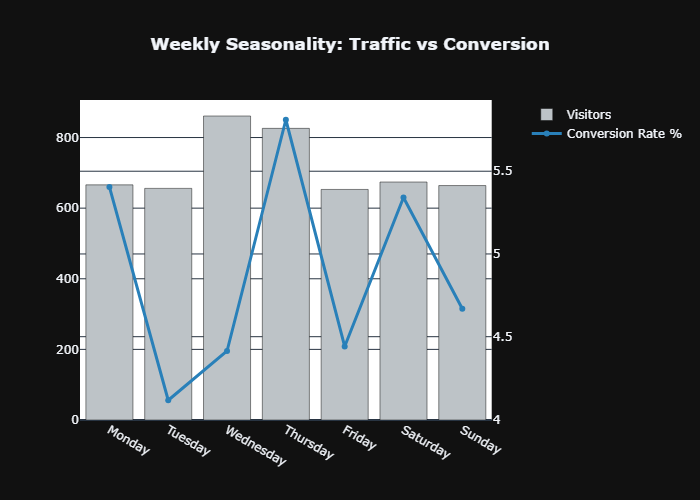

--- Detailed Weekly Metrics ---


,Visitors,Bookings,Revenue,CVR,AOV
dow,,,,,
Monday,666,36,"$36,533",5.41%,$1014.80
Tuesday,656,27,"$29,363",4.12%,$1087.50
Wednesday,861,38,"$41,217",4.41%,$1084.66
Thursday,826,48,"$53,871",5.81%,$1122.31
Friday,653,29,"$29,698",4.44%,$1024.05
Saturday,674,36,"$39,866",5.34%,$1107.39
Sunday,664,31,"$37,768",4.67%,$1218.34


In [32]:
data_visualizer.plot_day_of_week_seasonality(clean_df)

### 2.11 Feature Correlation: The "Zero Linear Signal" Trap

**Objective:**
If the predictive variables are colinear then they become redundant (multicollinear).  It is necessary to ensure our features are not highly correlated (Multicollinearity) and to check for obvious linear drivers of conversion.


**Key Findings:**

1.  **Safety Check Passed (No Multicollinearity):**
    * The highest correlation is between `distance_km` and `seats_left` (0.42).
    * Critically, `price_shown` is **not** strongly correlated with `distance_km` (-0.10).
    * *Conclusion:* We do not need to drop features for technical reasons. The model can handle these distinct inputs without "confusion."

2.  **The "Zero Correlation" Trap:**
    * **Price vs. Booked is 0.00.**
    * *Interpretation:* Does this mean price doesn't affect bookings? **No.** It means the relationship is **non-linear** and **segment-dependent**.
    * *Example:* A \$50 price might be "Cheap" for a Flight (High CVR) but "Expensive" for a Bus (Low CVR). When you average them, they cancel out to zero.
    * *Action:* This proves that a simple Linear Regression will fail. We *must* use a Machine Learning model (like Random Forest or XGBoost) that can learn "Contextual Pricing" (e.g., "Price matters, *if* transport is Bus").

3.  **Structural Leakage Confirmed:**
    * The `NaN` correlation between `booked` and `seats_left` confirms that `seats_left` is a post-conversion artifact. We must **exclude** it from our predictive features to prevent Data Leakage.

In [33]:
data_visualizer.plot_correlation_matrix(clean_df)

--- Correlation Coefficients ---


,price_shown,distance_km,duration_min,seats_left,days_to_trip,popularity_score,booked
price_shown,1.00,-0.10,0.31,-0.11,0.06,-0.00,-0.00
distance_km,-0.10,1.00,0.31,0.42,0.02,-0.00,0.02
duration_min,0.31,0.31,1.00,0.07,0.04,0.00,0.01
seats_left,-0.11,0.42,0.07,1.00,-0.07,-0.03,nan
days_to_trip,0.06,0.02,0.04,-0.07,1.00,-0.03,nan
popularity_score,-0.00,-0.00,0.00,-0.03,-0.03,1.00,0.00
booked,-0.00,0.02,0.01,nan,nan,0.00,1.00


## 3. Predictive Modeling: The Price Elasticity Funnel

### 1. Objective: The "Small Data" Challenge
We must quantify how **Price** impacts behavior, but face a "Trilemma":
1.  **Small Sample ($N=5,000$):** High overfitting risk.
2.  **Imbalance:** Conversions are rare (~5%).
3.  **Causality:** We need stable elasticity, not just accuracy.

The *Benchmarking Strategy*, pits multiple architectures against each other to isolate the signal.

### 2. The Strategy: Stage-Wise Propensity
We model the probability of reaching each funnel stage to detect where price sensitivity peaks.

| Model | Target | Population | Goal |
| :--- | :--- | :--- | :--- |
| **Model A (Interest)** | `clicked_trip` | All Visitors | **Top Funnel:** Prob. of clicking a trip. |
| **Model B (Intent)** | `added_to_cart` | All Visitors | **Mid Funnel:** Prob. of adding to cart. |
| **Model C (Conversion)** | `booked` | All Visitors | **Bottom Funnel:** Prob. of booking. |

### 3. Methodology: The Model "Horse Race"
Three approaches are benchmarked for each stage:

1.  **Econometric Baseline (Linear):**
    * **Technique:** **Logistic Regression (ElasticNet).** Acts as a performance floor and "sanity check" for elasticity direction.

2.  **Industrial Standards (Tree Ensembles):**
    * **Techniques:** **Random Forest, XGBoost, CatBoost.** Captures non-linear interactions (e.g., Device x Price) while enforcing economic constraints.

3.  **Imbalance Specialist:**
    * **Technique:** **Balanced Bagging.** Aggressively resamples data to force learning from the minority class (Bookings).

3.  **Deep Learning (Attention-Based):**
    * **Technique:** **TabNet.** A deep neural network designed for tabular data that uses sequential attention to choose which features to reason from at each decision step, offering interpretability akin to decision trees.

### 4. Evaluation Metrics
* **PR-AUC:** Optimizes for finding rare positive cases (buyers).
* **Brier Score:** Ensures probabilistic calibration (crucial for accurate revenue estimation).

In [34]:
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="shap")
from IPython.display import display, Markdown
from features import FeatureEngineering
from modeling import (
    FunnelModeler, XGBoostModel, RandomForestModel,
    CatBoostModel, BalancedBaggingModel, TabNetModel, ModelArena,
    get_configured_logistic_model
)
from sklearn.metrics import average_precision_score, brier_score_loss


# --- 1. FEATURE ENGINEERING ---
cols_to_scale = [
    'duration_min', 'distance_km', 'baseline_price', 'competitor_price',
    'price_shown', 'price_ratio_vs_competitor', 'route_views_last_24h',
    'ATC_rate_last_24h', 'conversion_rate_last_7d', 'popularity_score'
]

cols_to_drop = [
    'trip_date', 'load_factor', 'seats_left', 'advance_booking_days',
    'price_paid', 'revenue', 'netprofit', 'visitor_id', 'visit_date',
    'days_until_trip'
]

cols_to_encode = ['device', 'os', 'visit_day', 'utm_source', 'country', 'trip_id', 'origin', 'destination', 'transport_type']

modeling_df = FeatureEngineering.prepare_modeling_data(clean_df, cols_to_encode, cols_to_drop)

modeling_df['price_per_km'] = modeling_df['price_shown'] / (modeling_df['distance_km'] + 1)
modeling_df['valuable_deal'] = modeling_df['price_ratio_vs_competitor'] * modeling_df['popularity_score']

train_df, test_df = FeatureEngineering.global_random_split(modeling_df)
train_df, test_df = FeatureEngineering.scale_numeric_features(train_df, test_df, cols_to_scale)

# --- 2. LINEAR DIAGNOSTICS ---
print("Training Linear Baselines...")
funnel = FunnelModeler()
funnel.train_all_stages(train_df, test_df)

# --- 3. MODEL ARENA ---
targets = ['clicked_trip', 'added_to_cart', 'booked']
best_models = {}
final_leaderboards = {}

for target in targets:
    print(f"\n{'='*20} Processing Target: {target} {'='*20}")

    # 1. Define Features
    leakage_cols = ['clicked_trip', 'added_to_cart', 'booked']
    technical_drops = leakage_cols + [c for c in train_df.columns if 'trip_id_' in c]

    X_train = train_df.drop(columns=technical_drops)
    y_train = train_df[target]
    X_test = test_df.drop(columns=technical_drops)
    y_test = test_df[target]

    # 2. RE-TRAIN Linear Baseline
    baseline_model = get_configured_logistic_model()
    baseline_model.fit(X_train, y_train)

    y_prob_base = baseline_model.predict_proba(X_test)[:, 1]
    baseline_metrics = {
        'pr_auc': average_precision_score(y_test, y_prob_base),
        'brier': brier_score_loss(y_test, y_prob_base)
    }

    # 3. Define Competitors (Added TabNet)
    competitors = [
        ("XGBoost", XGBoostModel()),
        ("Random Forest", RandomForestModel()),
        ("CatBoost", CatBoostModel()),
        ("TabNet (Deep Learning)", TabNetModel()), # <--- NEW COMPETITOR
        ("Balanced Bagging", BalancedBaggingModel())
    ]

    # 4. Run the Horse Race
    leaderboard = ModelArena.run_competition(
        competitors, X_train, y_train, X_test, y_test,
        baseline_metrics, baseline_model
    )

    # 5. Display Results
    baseline_pr = y_test.mean()
    leaderboard['Lift_vs_Random'] = leaderboard['PR_AUC'] / baseline_pr
    final_leaderboards[target] = leaderboard

    display(Markdown(f"### Leaderboard: {target.replace('_', ' ').title()}"))
    display(leaderboard[['Model', 'PR_AUC', 'Brier_Score', 'Lift_vs_Random']]
            .style.background_gradient(cmap='Greens', subset=['PR_AUC'])
            .format({'PR_AUC': "{:.4f}", 'Lift_vs_Random': "{:.2f}x"}))

    # 6. Winner Analysis
    best_row = leaderboard.iloc[0]
    best_name = best_row['Model']
    best_obj = best_row['Object']
    print(f"   Champion: {best_name}")

    best_models[target] = {
        'name': best_name,
        'object': best_obj,
        'X_test': X_test
    }

Scaling 10 numeric features...
Training Linear Baselines...

==================== Processing Target: clicked_trip ====================


### Leaderboard: Clicked Trip

,Model,PR_AUC,Brier_Score,Lift_vs_Random
4,TabNet (Deep Learning),0.2882,0.251215,1.18x
0,Linear (Baseline),0.2849,0.249309,1.17x
5,Balanced Bagging,0.2705,0.243463,1.11x
1,XGBoost,0.2621,0.554204,1.07x
2,Random Forest,0.2612,0.241584,1.07x
3,CatBoost,0.2569,0.239081,1.05x


   Champion: TabNet (Deep Learning)

==================== Processing Target: added_to_cart ====================


### Leaderboard: Added To Cart

,Model,PR_AUC,Brier_Score,Lift_vs_Random
0,Linear (Baseline),0.1527,0.247031,1.17x
3,CatBoost,0.1356,0.196334,1.04x
5,Balanced Bagging,0.1321,0.232636,1.02x
4,TabNet (Deep Learning),0.1318,0.241003,1.01x
1,XGBoost,0.1267,0.441661,0.97x
2,Random Forest,0.1265,0.221053,0.97x


   Champion: Linear (Baseline)

==================== Processing Target: booked ====================


### Leaderboard: Booked

,Model,PR_AUC,Brier_Score,Lift_vs_Random
4,TabNet (Deep Learning),0.0868,0.232163,1.77x
2,Random Forest,0.0627,0.175770,1.28x
5,Balanced Bagging,0.0470,0.215901,0.96x
3,CatBoost,0.0465,0.107418,0.95x
1,XGBoost,0.0446,0.209665,0.91x
0,Linear (Baseline),0.0432,0.246208,0.88x


   Champion: TabNet (Deep Learning)


## 4. Optimized Feature Selection: Stepwise Regression

### The Problem: Signal vs. Noise
In the previous step (the "Horse Race"), we fed the models **every available feature** (the "Kitchen Sink" approach). While trees (XGBoost) can handle this, Linear Models often degrade when overwhelmed by irrelevant variables or collinear noise.

To build a robust, interpretable economic model, we need to strip away the noise and train only on the "Good Features."
Features are added or subtracted one by one, if a feature does not improve performance, then it is skipped.

### The Solution: Forward Stepwise Selection
We implement an iterative **Forward Selection** algorithm to build the model from scratch:

1.  **Start Empty:** Begin with zero features.
2.  **Scan:** Test every available column to see which one maximizes **PR-AUC**.
3.  **Add Best:** Permanently add the winner to the model.
4.  **Repeat:** Continue adding features until performance stops improving.

**The "Strategic" Twist:**
Standard stepwise selection might drop **Price** if it is overpowered by strong variables like `route_id`. To prevent this, we use a **"Pass List"**: we force the model to keep pricing metrics as long as they do not *negatively* impact performance ("Do No Harm").

This results in a clean, highly optimized model containing only the features that truly drive user behavior.

In [35]:
from experimental_utils import LeaderboardReporter, TabNetStepwiseSelector

# 1. Setup Data
target_var = 'booked'
X_train_step = train_df.drop(columns=technical_drops)
y_train_step = train_df[target_var]
X_test_step = test_df.drop(columns=technical_drops)
y_test_step = test_df[target_var]

# 2. Run Selector
# (Returns the finished model object and internal results dict)
selector = TabNetStepwiseSelector(
    X_train=X_train_step, y_train=y_train_step,
    X_test=X_test_step, y_test=y_test_step,
    initial_features=list(X_train_step.columns)[0:1]
)

model = selector.run(max_cycles=3)


--- Starting TabNet Selection (Inclusive Strategy) ---
Baseline Score: 0.05225

=== CYCLE 1 ===
[SKIP]  Col duration_min | Feature 1/58 | Cycle 1 | Score: 0.04418 (Best: 0.05225)
[SKIP]  Col distance_km | Feature 2/58 | Cycle 1 | Score: 0.05087 (Best: 0.05225)
[SKIP]  Col baseline_price | Feature 3/58 | Cycle 1 | Score: 0.05172 (Best: 0.05225)
[SKIP]  Col competitor_price | Feature 4/58 | Cycle 1 | Score: 0.04803 (Best: 0.05225)
[SKIP]  Col price_shown | Feature 5/58 | Cycle 1 | Score: 0.04512 (Best: 0.05225)
[SKIP]  Col price_ratio_vs_competitor | Feature 6/58 | Cycle 1 | Score: 0.04471 (Best: 0.05225)
[SKIP]  Col discount_flag | Feature 7/58 | Cycle 1 | Score: 0.04324 (Best: 0.05225)
[SKIP]  Col markup_flag | Feature 8/58 | Cycle 1 | Score: 0.04913 (Best: 0.05225)
[ADDED] Col returning_user | Feature 9/58 | Cycle 1 | Score: 0.05504
[ADDED] Col route_views_last_24h | Feature 10/58 | Cycle 1 | Score: 0.08175
[SKIP]  Col ATC_rate_last_24h | Feature 11/58 | Cycle 1 | Score: 0.05943 (Best

In [36]:

reporter = LeaderboardReporter(targets=['booked'])

final_leaderboards = reporter.update_and_display(
    current_boards=final_leaderboards,
    selection_results=selector.selection_results,
    test_df=test_df,
    train_columns=train_df.columns
)

### Leaderboard: Booked

,Model,PR_AUC,Brier_Score,Lift_vs_Random
0,Optimized TabNet (Stepwise),0.1337,0.2514,2.73x
1,TabNet (Deep Learning),0.0868,0.2322,1.77x
2,Random Forest,0.0627,0.1758,1.28x
3,Balanced Bagging,0.0470,0.2159,0.96x
4,CatBoost,0.0465,0.1074,0.95x
5,XGBoost,0.0446,0.2097,0.91x
6,Linear (Baseline),0.0432,0.2462,0.88x


The Stepwise Regression provides the greatest lift, but also shows the highest Brier score.

In [37]:
from experimental_utils import run_simple_simulation

# 1. Run the simulation
comp_sim_df = run_simple_simulation(
    models_board=final_leaderboards['booked'],
    selector=selector,
    X_test=test_df
)

# 2. Calculate Elasticity without Lambda
elasticity_values = []

for index, row in comp_sim_df.iterrows():
    volume_change = row['Volume_Impact_%']

    if "Up" in row['Scenario']:
        # Price went +10%
        e = volume_change / 10
    else:
        # Price went -10%
        # Formula: % Vol Change / % Price Change (-10)
        e = volume_change / -10

    elasticity_values.append(e)

# Add the list as a new column
comp_sim_df['Elasticity'] = elasticity_values

# 3. Clean up the index and display
comp_sim_df = comp_sim_df.reset_index(drop=True)

display(Markdown("### Pricing Strategy & Elasticity Report"))

display(comp_sim_df.style
        .background_gradient(cmap='RdYlGn', subset=['Profit_Impact_%'])
        .background_gradient(cmap='RdBu_r', subset=['Elasticity'], vmin=-1, vmax=1)
        .format({
            'Volume_Impact_%': "{:+.2f}%",
            'Profit_Impact_%': "{:+.2f}%",
            'Elasticity': "{:.3f}"
        }))

### Pricing Strategy & Elasticity Report

,Model,Scenario,Volume_Impact_%,Profit_Impact_%,Elasticity
0,Optimized TabNet (Stepwise),Price Up (+10%),+0.00%,+50.00%,0.000
1,Optimized TabNet (Stepwise),Price Down (-10%),+0.00%,-50.00%,-0.000
2,TabNet (Deep Learning),Price Up (+10%),+0.04%,+50.06%,0.004
3,TabNet (Deep Learning),Price Down (-10%),-0.04%,-50.02%,0.004
4,Random Forest,Price Up (+10%),-0.32%,+49.52%,-0.032
5,Random Forest,Price Down (-10%),+0.05%,-49.97%,-0.005
6,Balanced Bagging,Price Up (+10%),+0.23%,+50.34%,0.023
7,Balanced Bagging,Price Down (-10%),-0.13%,-50.07%,0.013
8,CatBoost,Price Up (+10%),-1.74%,+47.39%,-0.174
9,CatBoost,Price Down (-10%),+0.39%,-49.81%,-0.039
